# Data Load

In [155]:
from kamp.preprocess import KampDataLoader

help(KampDataLoader)

Help on class KampDataLoader in module kamp.preprocess:

class KampDataLoader(builtins.object)
 |  KampDataLoader(path, nan_grid={'drop_features': ['line', 'name', 'mold_name', 'time', 'date', 'emergency_stop', 'molten_volume', 'registration_time'], 'simple_fill_dict': {'tryshot_signal': 'No', 'heating_furnace': 'C'}, 'mode_fill_features': ['upper_mold_temp3', 'lower_mold_temp3', 'molten_temp'], 'mode_criterion': 'mold_code'}, do_count_trend=True, drop_count=True, encode_grid={'working': ['정지', '가동'], 'tryshot_signal': ['No', 'D'], 'heating_furnace': ['A', 'B', 'C'], 'mold_code': [8412, 8413, 8573, 8576, 8600, 8722, 8917]}, outlier_method='iso', iso_outlier_rate=0.015, p_threshold=0.05, get_useful_p_data=False, do_resample=True, downsampled_pass_rate=0.5, upsampled_fail_rate_about_pass=1.0, upsample_method='smote', do_pca=False, variance_rate=0.95)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, path, nan_grid={'drop_features': ['line', 'name', 'mold_name', 'time', 'date', 'emer

In [156]:
DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    # 처리 안한게 더 좋았음
    # 처리 안한 것 : 0.944
    # 처리 한 것 : 최대 0.922
    do_count_trend=False,
    drop_count=False,

    get_useful_p_data=True,
    p_threshold=0.05,

    outlier_method='iso',
    iso_outlier_rate=0.0075,

    do_resample=True,
    downsampled_pass_rate=1.0,
    upsampled_fail_rate_about_pass=0.25,
    upsample_method='adasyn',
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[Process Log] Loading Raw Data...
[Process Log] Done

[Process Log] Processing Nan Value...
[Process Log] Done

[Process Log] Encoding Categorical Features...
[Process Log] Done

[Process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (89753, 23)
[Outlier-Remover Log] Without Outliers Shape : (89079, 23)
[Process Log] Done

[Process Log] T-Testing...
[Process Log] Done

[Process Log] Data Scaling (MinMaxScaler)...
[Process Log] Done

[Process Log] Train Test Spliting...
[Process Log] Done

[Process Log] Data Resampling (adasyn)...
[Process Log] Done

======================= [Done] =======================


# Modeling

In [157]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

In [ ]:
# model = LGBMClassifier(random_state=42)
# model = ExtraTreesClassifier(random_state=42)
# model = RandomForestClassifier(random_state=42)
model = XGBClassifier(random_state=42)

fold_f1_score = []
n_iter = 0
idx_list = []

for train_idx, val_idx in strat_folder.split(x_train, y_train):
    train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
    train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(train_data, train_label)

    val_pred = model.predict(val_data)
    val_f1_score = f1_score(val_label, val_pred)
    val_report = classification_report(val_label, val_pred)

    n_iter += 1
    fold_f1_score.append([n_iter, val_f1_score])
    idx_list.append([train_idx, val_idx])

    print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 Report : \n{val_report}")

fold_f1_score.sort(key=lambda x : x[1], reverse=True)
print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

[LightGBM] [Info] Number of positive: 13679, number of negative: 54912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3329
[LightGBM] [Info] Number of data points in the train set: 68591, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199428 -> initscore=-1.389870
[LightGBM] [Info] Start training from score -1.389870
StratifiedShuffleSplit 1 검증 데이터 Report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13728
         1.0       0.99      0.99      0.99      3420

    accuracy                           1.00     17148
   macro avg       0.99      0.99      0.99     17148
weighted avg       1.00      1.00      1.00     17148

[LightGBM] [Info] Number of positive: 13679, number of negative: 54912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

In [159]:
best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

[LightGBM] [Info] Number of positive: 13679, number of negative: 54912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 68591, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199428 -> initscore=-1.389870
[LightGBM] [Info] Start training from score -1.389870


LGBMClassifier(random_state=42)

# Validation

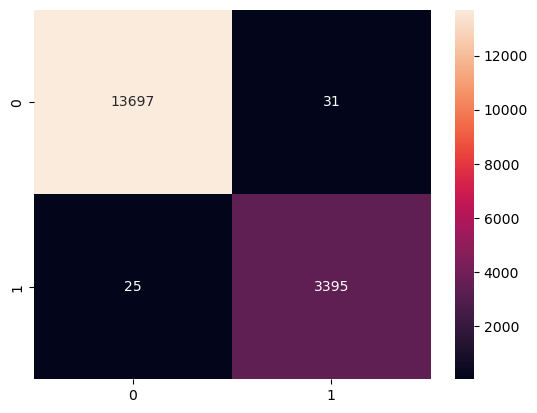

In [160]:
pred = model.predict(x_train.iloc[best_fold_val_idx])

cm = confusion_matrix(y_train[best_fold_val_idx], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

# Testing

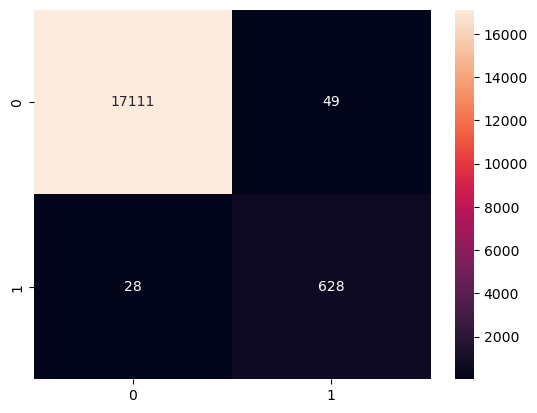

In [161]:
pred = model.predict(x_test)

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

In [162]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17160
         1.0       0.93      0.96      0.94       656

    accuracy                           1.00     17816
   macro avg       0.96      0.98      0.97     17816
weighted avg       1.00      1.00      1.00     17816



In [163]:
print(f1_score(y_test, pred))

0.9422355588897224
